# Notebook to Preprocess MIMIC-III v1.4 Data Files

In this notebook we will preprocess the [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) v1.4 data files as extracted by [MIMIC-Code](https://github.com/MIT-LCP/mimic-code). Here, we implement the preprocessing for the *handcrafted state-space approach* as used by [Roggeveen et al.](https://www.sciencedirect.com/science/article/pii/S0933365720312689), by aggregating measurements into bins of 4-hours starting from the 24 hour prior to sepsis onset to 48 hours after (72 hours in total).

The [original notebook](https://github.com/LucaMD/SRL/blob/master/SEPSIS/MIMIC_src/MIMIC_R_DataPreprocessing.ipynb) used to preprocess the datafiles was written in R; I have reimplemented the preprocessing in Python and validated this reimplementation with the original (minus small errors made in the original which I corrected, see `# Remark:` comments in the code cells below).

Moreover, the original notebook restricted the preprocessing to records stored in the MetaVision file system as CareVue files were assumed not to contain the necessary `starttimes` for treatments. Although this is partially true, using additonal preprocessing in `convert_cv_to_mv.ipynb` we were able to reconstruct the `starttimes` for CareVue records (as described in the [MIMIC-III docs](https://mimic.mit.edu/docs/iii/about/io/)), allowing us to expand our sepsis cohort with additional patients.

In [1]:
## Dependencies
# I/O
import os
import re
import pickle
import pandas as pd
import numpy as np

# Plotting
import random
import matplotlib.pyplot as plt

# Timing
from datetime import timedelta
from tqdm import tqdm

# Imputation
from fancyimpute import KNN

# Suppress scientific notation
np.set_printoptions(suppress=True)

# Settings
INTERVAL_TIME = '1h'
USE_CAREVUE = False
DATA_DIR = '../data/mimic-iii/final/'             # Where mimic-iii is kept
OUTPUT_DIR = 'datasets/mimic-iii/aggregated_all'  # Where preprocessed data will be stored

In [2]:
# Check if mimic-iii folder exists
if not os.path.exists(DATA_DIR):
    raise Exception('Dataset directory %s does not exist!' % DATA_DIR)

# Create OUTPUT_DIR
OUTPUT_DIR = OUTPUT_DIR + '_%s%s/' % (INTERVAL_TIME, '_with_cv' if USE_CAREVUE else '')
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

<br>

**Convenience functions**<br>
For simplicity, we define a number of convenience functions we can reuse throughout the notebook (for loading data, plotting, unit conversions, etc.);

In [3]:
# reads a .csv file and parses datetime columns using pd.to_datetime()
def read_csv(fname):
    df = pd.read_csv(fname)
    
    # Mad explicit as parse_dates=True fails to cast starttime and endtime as timestamps
    parse_dates = ['intime', 'outtime', 'starttime', 'endtime', 'window_start', 
                   'window_end', 'charttime', 'suspected_infection_time_poe']
    
    for col in parse_dates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df

# Plots random afeature of admission
def plot_random(df, key, icustay_id=None):
    if icustay_id is None:
        icustay_id = random.choice(df.icustay_id.unique())
        
    icustay = df[df.icustay_id == icustay_id]
    
    plt.figure(figsize=(10, 3))
    plt.plot(icustay.timestep, icustay[key], color='C0', linestyle='-')
    plt.plot(icustay.timestep, icustay[key], color='C0', marker='.')
    plt.plot()
    return icustay_id

# plots values of under `key` over time
def plot_single(dct, key, title='', xlabel='Timestep', ylabel='Value', style='.-'):
    icustay_id = None
    x = None
    y = None
    
    icustay_ids = list(dct.keys())
    while x is None:
        # Pick a random ICU stay from dct
        icustay_id = random.choice(icustay_ids)
        
        # Continue if no data logged for key
        if key not in dct[icustay_id]:
            continue
        
        # Continue if values are all zeros/NaNs (e.g. to mark no fluids were administered)
        data = np.nan_to_num(dct[icustay_id][key])
        if np.max(data) > 0:
            x = dct[icustay_id]['timestep']
            y = data
            
    if len(x) > len(y):
        x = x[:len(y)]
                            
    plt.figure(figsize=(8, 3))
    plt.plot(x, y, style, label=str(icustay_id))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Converts a series of deltatime objects into hours
def to_hours(x):
    return x.astype('timedelta64[s]').astype(int) / 3600

# Converts upper- or camelcase to snake-case (lowercase with '_' separators)
def to_snakecase(string):
    if string.islower():
        return string
    elif string.isupper():
        return string.lower()
    else:
        string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
        return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()
    
print('HeartRate => %s' % to_snakecase('HeartRate'))
print('ALBUMIN   => %s' % to_snakecase('ALBUMIN'))
print('MeanBP    => %s' % to_snakecase('MeanBP'))

HeartRate => heart_rate
ALBUMIN   => albumin
MeanBP    => mean_bp


---
## Patient Cohort

Using MIMIC-Code we have extracted a *sepsis-3* cohort (i.e. a list of patients satisfying the sepsis-3 criteria (Singer et al., 2016)) along with information regarding the suspected time of infection and in-hospital mortality. Let's first import these data;

In [4]:
cohort_df = read_csv(DATA_DIR + 'cohort.csv')
print('Number of admissions: %s\n' % len(cohort_df))
cohort_df.head()

Number of admissions: 38248



,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,3,145834,211552,2101-10-20 19:10:11,2101-10-26 20:43:09,NaT,2101-10-20 19:10:11,2101-10-23 19:10:11,0
1,4,185777,294638,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-16 00:00:00,2191-03-15 00:00:00,2191-03-18 00:00:00,0
2,6,107064,228232,2175-05-30 21:30:54,2175-06-03 13:39:54,NaT,2175-05-30 21:30:54,2175-06-02 21:30:54,0
3,9,150750,220597,2149-11-09 13:07:02,2149-11-14 20:52:14,2149-11-10 09:23:00,2149-11-09 09:23:00,2149-11-12 09:23:00,1
4,11,194540,229441,2178-04-16 06:19:32,2178-04-17 20:21:05,NaT,2178-04-16 06:19:32,2178-04-19 06:19:32,0


<br>

**Collecting the data in `data_all`**<br>
For convenience, we will collect features in a dict `data_all`, mapping from each admission (`icustay_id`) to the corresponding data of features (`heart_rate`, `sys_bp`, `wbc`) or actions (e.g. `max_vaso`);

In [5]:
# We will store our data in this
data_all = {icustay_id:dict() for icustay_id in cohort_df['icustay_id'].values}

# See? empty...
assert data_all[255559] == {}

---

## 4-Hour Time Intervals

For each 72-hour time window (spanning 24h prior to sepsis onset to 48h after) we will precompute all intermediate timesteps in increments of $\Delta t=4$ hours (defined by `INTERVAL_TIME`). Each time we add our output to `data_all`;

In [6]:
def date_range(icustay, freq):
    starttime = icustay['window_start']
    endtime = icustay['window_end']
    return pd.date_range(start=starttime, end=endtime, freq=freq).values
    
icustay_timesteps = {icustay['icustay_id']: date_range(icustay, freq=INTERVAL_TIME) for _, icustay in cohort_df.iterrows()}

In [7]:
for icustay_id, timesteps in icustay_timesteps.items():
    data_all[icustay_id]['timestep'] = timesteps

In [8]:
# Plot timesteps of random admission
data_all[255559]

{'timestep': array(['2150-09-15T16:12:00.000000000', '2150-09-15T17:12:00.000000000',
        '2150-09-15T18:12:00.000000000', '2150-09-15T19:12:00.000000000',
        '2150-09-15T20:12:00.000000000', '2150-09-15T21:12:00.000000000',
        '2150-09-15T22:12:00.000000000', '2150-09-15T23:12:00.000000000',
        '2150-09-16T00:12:00.000000000', '2150-09-16T01:12:00.000000000',
        '2150-09-16T02:12:00.000000000', '2150-09-16T03:12:00.000000000',
        '2150-09-16T04:12:00.000000000', '2150-09-16T05:12:00.000000000',
        '2150-09-16T06:12:00.000000000', '2150-09-16T07:12:00.000000000',
        '2150-09-16T08:12:00.000000000', '2150-09-16T09:12:00.000000000',
        '2150-09-16T10:12:00.000000000', '2150-09-16T11:12:00.000000000',
        '2150-09-16T12:12:00.000000000', '2150-09-16T13:12:00.000000000',
        '2150-09-16T14:12:00.000000000', '2150-09-16T15:12:00.000000000',
        '2150-09-16T16:12:00.000000000', '2150-09-16T17:12:00.000000000',
        '2150-09-16T18:12:

---
## Vasopressors

### 1. MetaVision Records

In [10]:
# Load data file from MIMIC-Code
vaso_mv_df = read_csv(DATA_DIR + 'vasopressors_mv_cohort.csv')
vaso_mv_df.head()

,icustay_id,starttime,endtime,rate,rateuom,patientweight,orderid,linkorderid,vasoactive_drug,mcgkgmin,mcgmin
0,200028,2133-10-29 17:47:00,2133-10-29 17:55:00,2.400000,units/hour,84.0,7084343,7084343,vasopressin,0.200000,0.200000
1,200028,2133-10-29 17:49:00,2133-10-29 18:11:00,0.060011,mcg/kg/min,84.0,6199431,6199431,norepinephrine,0.060011,5.040958
2,200028,2133-10-29 18:11:00,2133-10-29 18:19:00,0.079998,mcg/kg/min,84.0,8992273,6199431,norepinephrine,0.079998,6.719846
3,200028,2133-10-29 18:19:00,2133-10-29 18:28:00,0.099976,mcg/kg/min,84.0,9514414,6199431,norepinephrine,0.099976,8.398007
4,200028,2133-10-29 18:28:00,2133-10-29 18:41:00,0.139967,mcg/kg/min,84.0,1284426,6199431,norepinephrine,0.139967,11.757210


**Computing maximum vasopressor dose**<br>

For each admission (i.e. ICU stay), we iterate over timesteps $t$ and determine which treatments overlap with its immediate 4 hour history (i.e. which treatments occurred between 4 hours ago and now). We then record the maximum rate of these treatments.

In [ ]:
# Consider ICU stays one-by-one
for icustay_id, treatments in tqdm(vaso_mv_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in data_all:
        continue
        
    # To store vasopressor doses into
    timesteps = icustay_timesteps[icustay_id]
    max_vaso = np.zeros(len(timesteps) - 1, dtype=np.float32)
    
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: treatment time overlaps with current interval.
        # Remark: original R-code erroneously used 'treatment[endtime] <= interval_end' as first term
        condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)
        
        # Compute max vasopressor intake in mcg/kg/min (norepinephrine-equivalent)
        max_vaso[i] = treatments[condition]['mcgkgmin'].max()
        max_vaso[i] = np.nan_to_num(max_vaso[i], nan=0.0)
        
    data_all[icustay_id]['max_vaso'] = max_vaso
    
del vaso_mv_df

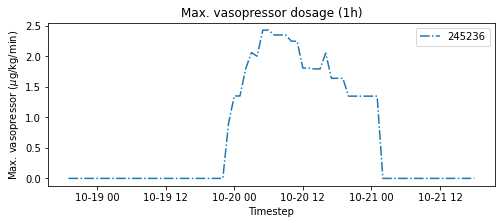

In [48]:
# Plot vasopressors of random admission
plot_single(data_all, key='max_vaso', title='Max. vasopressor dosage (%s)' % INTERVAL_TIME, ylabel='Max. vasopressor ($\mu$g/kg/min)', style='-.')

**Sanity checks**

In [50]:
# Does the action space look like Roggeveen et al.?
max_vasos = np.row_stack([x['max_vaso'] for x in data_all.values() if 'max_vaso' in x]).flatten()

# Drop overrepresented zero doses
max_vasos = max_vasos[max_vasos > 0]

np.quantile(max_vasos, np.linspace(0, 1, 5)).round(4) # Approved!

array([  0.002 ,   0.1001,   0.225 ,   0.45  , 222.7312])

Compare with quartiles from (Roggeveen et al., 2021):
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-8jgo{border-color:#ffffff;text-align:center;vertical-align:top}
</style>
<table class="tg" align="left">
<thead>
  <tr>
    <th class="tg-8jgo">0%</th>
    <th class="tg-8jgo">25%</th>
    <th class="tg-8jgo">50%</th>
    <th class="tg-8jgo">75%</th>
    <th class="tg-8jgo">100%</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-8jgo">0.002</td>
    <td class="tg-8jgo">0.11016</td>
    <td class="tg-8jgo">0.22509</td>
    <td class="tg-8jgo">0.45035</td>
    <td class="tg-8jgo">222.73125</td>
  </tr>
</tbody>
</table>

<br><br><br>

Do note, these pertain to sepsis patients only and will hence differ slightly from those obtained here.

### 2. CareVue Records (optional)

In case `USE_CAREVUE` is enabled, we repeat the above process for the (converted) CareVue files.

In [ ]:
if USE_CAREVUE:
    # Load preprocessed CV vasopressor file
    vaso_cv_df = read_csv(DATA_DIR + 'vassopressors_cv_cohort_v2.csv')
    
    for icustay_id, treatments in tqdm(vaso_cv_df.groupby('icustay_id')):
        
        # Is icustay part of cohort?
        if icustay_id not in data_all:
            continue
            
        # Skip if already stored in MV
        if 'max_vaso' in data_all[icustay_id]:
            continue

        # To store vasopressor doses into
        timesteps = icustay_timesteps[icustay_id]
        max_vaso = np.zeros(len(timesteps) - 1, dtype=np.float32)

        for i, interval_start in enumerate(timesteps[:-1]):
            interval_end = timesteps[i + 1]

            # Inclusion test: treatment time overlaps with current interval.
            condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)

            # Compute max vasopressor intake in mcg/kg/min (norepinephrine-equivalent)
            max_vaso[i] = treatments[condition]['mcgkgmin'].max()
            max_vaso[i] = np.nan_to_num(max_vaso[i], nan=0.0)

        data_all[icustay_id]['max_vaso_cv'] = max_vaso  # Mark it has been logged by CV

    del vaso_cv_df

In [ ]:
# Plot vasopressors of random admission stored in CV
if USE_CAREVUE:
    plot_single(data_all, key='max_vaso_cv', title='Max. vasopressor dosage (%s)' % INTERVAL_TIME, ylabel='Max. vasopressor ($\mu$g/kg/min)', style='-.')

In [ ]:
# Does the action space look like Roggeveen et al.?
if USE_CAREVUE:
    max_vasos = np.row_stack([x['max_vaso_cv'] for x in data_all.values() if 'max_vaso_cv' in x]).flatten()
    max_vasos = max_vasos[max_vasos > 0]  # Drop zeros
    print(np.quantile(max_vasos, np.linspace(0, 1, 5)).round(4))  #

**Merge with MV**

In [52]:
# Merge CV records with max_vaso logged under MV
if USE_CAREVUE:
    for icustay_id in data_all.keys():
        if 'max_vaso_cv' in data_all[icustay_id]:
            data_all[icustay_id]['max_vaso'] = data_all[icustay_id].pop('max_vaso_cv')
print('Done!')

Done!


---
## IV Fluids

### 1. MetaVision Records

In [53]:
# See (Komorowski et al., 2018) 
# https://github.com/matthieukomorowski/AI_Clinician/blob/master/AIClinician_Data_extract_MIMIC3_140219.ipynb
TONICITY_FACTORS = {
    30176: 0.25,
    30315: 0.25,
    30161: 0.3,
    30020: 0.5,
    30015: 0.5,
    225823: 0.5,
    30321: 0.5,
    30186: 0.5,
    30211: 0.5, 
    30353: 0.5,
    42742: 0.5,
    42244: 0.5,
    225159: 0.5,
    227531: 2.75,
    30143: 3,
    225161: 3,
    30009: 5,
    220862: 5,
    30030: 6.66,
    220995: 6.66,
    227533: 6.66,
    228341: 8
}

# Remark: Komorowski et al. missed 220949, 'Dextrose 5%' (isotonic), amounting to 40% of IV fluids!
IV_FLUID_ITEMIDS = {225158,225943,226089,225168,225828,225823,220862,220970,220864,225159,220995,225170,
                    225825,227533,225161,227531,225171,225827,225941,225823,225825,225941,225825,228341,
                    225827,30018,30021,30015,30296,30020,30066,30001,30030,30060,30005,30321,30006,30061,
                    30009,30179,30190,30143,30160,30008,30168,30186,30211,30353,30159,30007,30185,30063,
                    30094,30352,30014,30011,30210,46493,45399,46516,40850,30176,30161,30381,30315,42742,
                    30180,46087,41491,30004,42698,42244,220949,225944,227523,-1} # -1 = AmsterdamUMCdb

NON_IV_CATEGORIES = ['14-Oral/Gastric Intake', 
                     '09-Antibiotics (Non IV)',
                     '13-Enteral Nutrition',
                     '06-Insulin (Non IV)',
                     '11-Prophylaxis (Non IV)',
                     '16-Pre Admission',
                     '09-Antibiotics (Non IV)']

**Drop non-IV fluid events**

In [54]:
ivfluid_mv_df = read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water) and other Non-IV input events
# Remark: In (Roggeveen et al., 2021) only '14-Oral/Gastric Intake' was dropped causing
# various Non-IV treatments (such as '13-Enteral Nutrition') to become part of IV fluids
ivfluid_mv_df = ivfluid_mv_df.loc[~ivfluid_mv_df.ordercategoryname.isin(NON_IV_CATEGORIES) & (ivfluid_mv_df.amountuom == 'ml')]

# Sanity check: remove amounts outside (0, 5000) range
ivfluid_mv_df = ivfluid_mv_df[(ivfluid_mv_df.amount > 0) & (ivfluid_mv_df.amount < 5000) & ivfluid_mv_df.amount.notna()]

# Compute duration in hours
# Remark: original erroneously measured time in a mix of hours and minutes (due to unit='auto')
ivfluid_mv_df['duration'] = to_hours(ivfluid_mv_df.endtime - ivfluid_mv_df.starttime)

# Drop unused columns
ivfluid_mv_df = ivfluid_mv_df[['icustay_id', 'itemid', 'starttime', 'endtime', 'amount', 'duration', 'ordercategoryname']]
ivfluid_mv_df.head()

,icustay_id,itemid,starttime,endtime,amount,duration,ordercategoryname
2,234044.0,220949,2157-10-21 15:00:00,2157-10-21 15:01:00,200.000000,0.016667,08-Antibiotics (IV)
4,234044.0,225158,2157-10-21 12:15:00,2157-10-21 13:22:00,13.432238,1.116667,01-Drips
7,234044.0,227523,2157-10-21 17:08:00,2157-10-21 18:08:00,49.999999,1.000000,02-Fluids (Crystalloids)
10,234044.0,220949,2157-10-22 08:00:00,2157-10-22 08:01:00,200.000000,0.016667,08-Antibiotics (IV)
14,234044.0,225158,2157-10-22 09:24:00,2157-10-22 09:48:00,1.602968,0.400000,01-Drips


**Correct for tonicity**

In [55]:
perc_iv_fluids = np.sum(ivfluid_mv_df.itemid.isin(IV_FLUID_ITEMIDS)) / len(ivfluid_mv_df)
print('%-known IV solutions:', perc_iv_fluids)

%-known IV solutions: 0.9504933676332894


In [56]:
def correct_for_tonicity(df):
    df = df[df.itemid.isin(IV_FLUID_ITEMIDS)].copy()
    for item_id, factor in TONICITY_FACTORS.items():
        df.loc[df.itemid == item_id, 'amount'] = factor * df.amount[df.itemid == item_id]
    return df

# Remark: Tonicity correction was not done in (Roggeveen et al., 2021) although standard practice
ivfluid_mv_df = correct_for_tonicity(ivfluid_mv_df)
ivfluid_mv_df.head()

,icustay_id,itemid,starttime,endtime,amount,duration,ordercategoryname
2,234044.0,220949,2157-10-21 15:00:00,2157-10-21 15:01:00,200.000000,0.016667,08-Antibiotics (IV)
4,234044.0,225158,2157-10-21 12:15:00,2157-10-21 13:22:00,13.432238,1.116667,01-Drips
7,234044.0,227523,2157-10-21 17:08:00,2157-10-21 18:08:00,49.999999,1.000000,02-Fluids (Crystalloids)
10,234044.0,220949,2157-10-22 08:00:00,2157-10-22 08:01:00,200.000000,0.016667,08-Antibiotics (IV)
14,234044.0,225158,2157-10-22 09:24:00,2157-10-22 09:48:00,1.602968,0.400000,01-Drips


**Computing total intake of IV fluids**<br>

In order to determine the total amount of IV fluid administered within a 4 hour interval, we need to calculate how long a treatment was administered for during an interval; multiplied by the rate (i.e. `amount / duration`) we can infer the total amount administered by each treatment during the current interval. For this we use the `total_admin_in_interval` function below:

In [57]:
# Computes how much of each dose was administered between interval_start and interval_end
def total_admin_in_interval(interval_start, interval_end, treatments):
    dose_start = treatments.starttime
    dose_end = treatments.endtime
    amount = treatments.amount
    duration = treatments.duration
    rate = amount / duration # in ml/hour!   
    
    total_ml = 0
    
    # Option 1: Dose started before interval and ended after interval
    c1 = (dose_start < interval_start) & (dose_end > interval_end)
    if c1.any():
        total_ml += (to_hours(interval_end - interval_start) * rate[c1]).sum()
    
    # Option 2: Dose started before and ended within interval
    c2 = (dose_start < interval_start) & (dose_end > interval_start) & (dose_end <= interval_end)
    if c2.any():
        total_ml += (to_hours(dose_end - interval_start) * rate[c2]).sum()

    # Option 3: Dose started and ended in interval
    c3 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end <= interval_end) & (dose_end > interval_start)
    if c3.any():
        total_ml += amount[c3].sum()
    
    # Option 4: dose started in interval and ended after interval
    # Remark: Extra division by duration in original notebook
    # Remark: In original notebook, > in first term causes treatments to be skipped starting exactly at interval start
    c4 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end > interval_end)
    if c4.any():
        total_ml += (to_hours(interval_end - dose_start) * rate[c4]).sum()
            
    return total_ml

We can now use `total_admin_in_interval()` on each interval `(interval_start, interval_end)` and treatment in `ivfluid_mv_df` to compute the total IV fluid administration:

In [58]:
for icustay_id, treatments in tqdm(ivfluid_mv_df.groupby('icustay_id'), desc='Grab some coffee'):
    
    # Is icustay part of cohort?
    if icustay_id not in data_all:
        continue
    
    # Store fluid intake in vector
    timesteps = icustay_timesteps[icustay_id]
    total_ivfluid = np.zeros(len(timesteps) - 1, dtype=np.float32)
    
    # Compute total IV fluid within each interval
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        total_ivfluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)
        
    # Save!
    data_all[icustay_id]['total_iv_fluid'] = total_ivfluid
    
del ivfluid_mv_df

Grab some coffee: 100%|██████████████████████████████████████████████████████████| 22641/22641 [56:19<00:00,  6.70it/s]


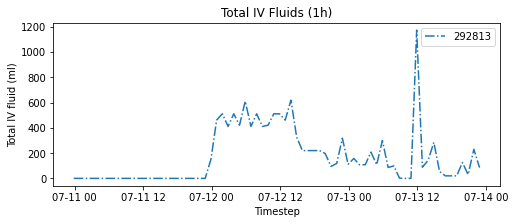

In [59]:
# Show IV fluids from random admission
plot_single(data_all, key='total_iv_fluid', title='Total IV Fluids (%s)' % INTERVAL_TIME, ylabel='Total IV fluid (ml)', style='-.')

**Sanity checks**

In [61]:
# Does the action space look like Roggeveen et al.?
iv_fluids = np.column_stack([x['total_iv_fluid'] for x in data_all.values() if 'total_iv_fluid' in x]).flatten()
iv_fluids = iv_fluids[iv_fluids >= 0.005]
np.nanquantile(iv_fluids, np.linspace(0, 1, 5)).round(3)

array([    0.007,    21.364,    84.723,   199.997, 11566.815])

<br>

Quartiles from (Roggeveen et al., 2021) are different (likely due to additional division by `duration`, see `#remark`, and tonicity correction):
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-8jgo{border-color:#ffffff;text-align:center;vertical-align:top}
</style>
<table class="tg" align="left">
<thead>
  <tr>
    <th class="tg-c3ow">0%</th>
    <th class="tg-c3ow">25%</th>
    <th class="tg-c3ow">50%</th>
    <th class="tg-c3ow">75%</th>
    <th class="tg-c3ow">100%</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-c3ow">0.000</td>
    <td class="tg-c3ow">39.834</td>
    <td class="tg-c3ow">204.403</td>
    <td class="tg-c3ow">635.205</td>
    <td class="tg-c3ow">24852.551</td>
  </tr>
</tbody>
</table>

### 2. CareVue Records (optional)
In case `USE_CAREVUE` is enabled, we repeat the above process for the (converted) CareVue files.

In [62]:
if USE_CAREVUE:
    ivfluid_cv_df = read_csv(DATA_DIR + 'inputevents_cv_cohort_v2.csv')

    # Sanity check: remove amounts outside (0, 5000) range
    # Note: OrderCategoryName -> 'Oral/Gastric' and unit = 'ml' already taken care of ;)
    ivfluid_cv_df = ivfluid_cv_df[(ivfluid_cv_df.amount > 0) & (ivfluid_cv_df.amount < 5000) & ivfluid_mv_df.amount.notna()]

    # Compute duration of IV administration
    ivfluid_cv_df['duration'] = to_hours(ivfluid_cv_df.endtime - ivfluid_cv_df.starttime)
    
    # Resample IV fluids
    for icustay_id, treatments in tqdm(ivfluid_cv_df.groupby('icustay_id'), desc='Grab another coffee'):
    
        if icustay_id not in data_all:
            continue
            
        # Skip if already stored in MV
        if 'total_iv_fluid' in data_all[icustay_id]:
            continue

        # Store fluid intake in vector
        timesteps = icustay_timesteps[icustay_id]
        total_ivfluid = np.zeros(len(timesteps) - 1, dtype=np.float32)

        # Compute total IV fluid within each interval
        for i, interval_start in enumerate(timesteps[:-1]):
            interval_end = timesteps[i + 1]
            total_ivfluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)

        # Save!
        data_all[icustay_id]['total_iv_fluid_cv'] = total_ivfluid  # Mark data came from CareVue

    del ivfluid_cv_df

In [63]:
# Show IV fluids from random admission stored in CV
if USE_CAREVUE:
    plot_single(data_all, key='total_iv_fluid_cv', title='Total IV Fluids (%s)' % INTERVAL_TIME, ylabel='Total IV fluid (ml)', style='-.')

In [64]:
# How many admissions have IV fluids registered?
if USE_CAREVUE:
    sum([1 if 'total_iv_fluid_cv' in adm else 0 for adm in data_all.values()])

**Merge with MV**

In [65]:
# Merge with total_iv_fluid logged by MV
if USE_CAREVUE:
    for icustay_id in data_all.keys():
        if 'total_iv_fluid_cv' in data_all[icustay_id]:
            data_all[icustay_id]['total_iv_fluid'] = data_all[icustay_id].pop('total_iv_fluid_cv')
print('Done!')

Done!


### IV Fluid Running Total 

In Roggeveen et al. an additional feature is incorporated which measures the total IV fluid administered up to the current timestep. We implement this here using `np.cumsum` over the previously computed IV fluid balances;

In [66]:
for icustay_id, icustay_data in data_all.items():
    if 'total_iv_fluid' in icustay_data.keys():
        data_all[icustay_id]['running_total_iv_fluid'] = np.cumsum(np.nan_to_num(icustay_data['total_iv_fluid'], nan=0.0))

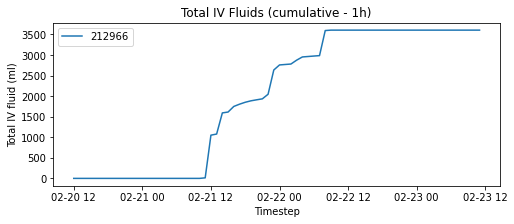

In [67]:
# Grab IV fluids from random patient
plot_single(data_all, key='running_total_iv_fluid', title='Total IV Fluids (cumulative - %s)' % INTERVAL_TIME, ylabel='Total IV fluid (ml)', style='-')

---
## Vital functions

In [68]:
vitals_df = read_csv(DATA_DIR + 'vitals_cohort.csv')
vitals_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,vital_id,valuenum
0,3,145834,211552,2101-10-20 19:10:11,2101-10-23 19:10:11,2101-10-20 19:10:11,2101-10-26 20:43:09,2101-10-20 19:14:00,Glucose,140.000000
1,3,145834,211552,2101-10-20 19:10:11,2101-10-23 19:10:11,2101-10-20 19:10:11,2101-10-26 20:43:09,2101-10-20 19:15:00,DiasBP,38.000000
2,3,145834,211552,2101-10-20 19:10:11,2101-10-23 19:10:11,2101-10-20 19:10:11,2101-10-26 20:43:09,2101-10-20 19:15:00,MeanBP,97.666702
3,3,145834,211552,2101-10-20 19:10:11,2101-10-23 19:10:11,2101-10-20 19:10:11,2101-10-26 20:43:09,2101-10-20 19:15:00,MeanBP,259.000000
4,3,145834,211552,2101-10-20 19:10:11,2101-10-23 19:10:11,2101-10-20 19:10:11,2101-10-26 20:43:09,2101-10-20 19:15:00,SpO2,74.000000


In [69]:
# List vitals recorded
ALL_VITALS = list(vitals_df['vital_id'].unique())
print(ALL_VITALS)

['Glucose', 'DiasBP', 'MeanBP', 'SpO2', 'SysBP', 'HeartRate', 'RespRate', 'TempC']


In [70]:
for icustay_id, measurements in tqdm(vitals_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add keys for each vital_id to data_all with empty measurements vector
    timesteps = icustay_timesteps[icustay_id]
    for vital_id in ALL_VITALS:
        data_all[icustay_id][to_snakecase(vital_id)] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] <= interval_end)  
        
        # Compute average value of each vital_id
        vital_means = measurements[condition].groupby('vital_id')['valuenum'].mean()
        
        for vital_id, value in vital_means.items():
            data_all[icustay_id][to_snakecase(vital_id)][i] = value
            
del vitals_df

100%|████████████████████████████████████████████████████████████████████████████| 34979/34979 [56:45<00:00, 10.27it/s]


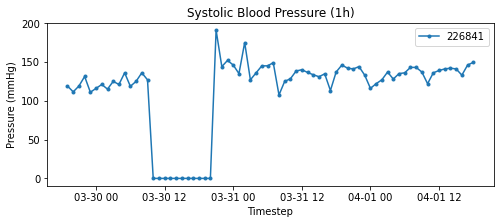

In [71]:
# Show SysBP from random patient
plot_single(data_all, key='sys_bp', title='Systolic Blood Pressure (%s)' % INTERVAL_TIME, ylabel='Pressure (mmHg)')

---
## Lab Results

In [72]:
lab_df = read_csv(DATA_DIR + 'labs_cohort.csv')

# Drop rows with NaNs
lab_df = lab_df.dropna(axis=0)

lab_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,lab_id,valuenum
0,3,145834,211552,2101-10-20 19:10:11,2101-10-23 19:10:11,2101-10-20 19:10:11,2101-10-26 20:43:09,2101-10-20 19:12:00,BaseExcess,-4.00
1,3,145834,211552,2101-10-20 19:10:11,2101-10-23 19:10:11,2101-10-20 19:10:11,2101-10-26 20:43:09,2101-10-20 19:12:00,ION_CALCIUM,1.09
2,3,145834,211552,2101-10-20 19:10:11,2101-10-23 19:10:11,2101-10-20 19:10:11,2101-10-26 20:43:09,2101-10-20 19:12:00,LACTATE,4.30
3,3,145834,211552,2101-10-20 19:10:11,2101-10-23 19:10:11,2101-10-20 19:10:11,2101-10-26 20:43:09,2101-10-20 19:12:00,PACO2,40.00
4,3,145834,211552,2101-10-20 19:10:11,2101-10-23 19:10:11,2101-10-20 19:10:11,2101-10-26 20:43:09,2101-10-20 19:12:00,PAO2,20.00


In [73]:
# List hormones / fluids measured
ALL_LAB_IDS = list(lab_df['lab_id'].unique())
print(ALL_LAB_IDS) 

['BaseExcess', 'ION_CALCIUM', 'LACTATE', 'PACO2', 'PAO2', 'PH', 'POTASSIUM', 'SODIUM', 'CHLORIDE', 'GLUCOSE', 'ANION GAP', 'BICARBONATE', 'BUN', 'CALCIUM', 'CREATININE', 'HEMOGLOBIN', 'MAGNESIUM', 'PLATELET', 'PT', 'PTT', 'WBC', 'ALAT', 'ALBUMIN', 'ASAT', 'BILIRUBIN', 'BANDS']


In [74]:
# Bin lab results into intervals
for icustay_id, lab_results in tqdm(lab_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add lab IDs to `data_all` to store aggregated lab measurements
    timesteps = icustay_timesteps[icustay_id]
    for lab_id in ALL_LAB_IDS:
        if lab_id not in data_all: # glucose is also measured more frequently as a vital
            data_all[icustay_id][to_snakecase(lab_id)] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (lab_results['charttime'] > interval_start) & (lab_results['charttime'] <= interval_end)  
        
        # Compute average value of each lab ID
        lab_means = lab_results[condition].groupby('lab_id')['valuenum'].mean()
        
        for item_id, value in lab_means.items():
            data_all[icustay_id][to_snakecase(item_id)][i] = value
            
del lab_df

100%|████████████████████████████████████████████████████████████████████████████| 36405/36405 [50:31<00:00, 12.01it/s]


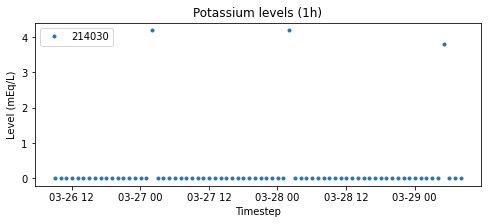

In [75]:
# Show potassium levels from random patient
plot_single(data_all, key='potassium', title='Potassium levels (%s)' % INTERVAL_TIME, ylabel='Level (mEq/L)', style='.')

Note the many missing values we have, i.e. gaps in the plot above, even when we plot the most frequently measured lab item (`potassium`) and bin these measurements into intervals of 4 hours.

---
## Urine Output

In [76]:
urine_df = read_csv(DATA_DIR + 'urineoutput_cohort.csv')

# Sanity check: drop values outside of expected range
urine_df = urine_df[(urine_df['value'] > 0) & (urine_df['value'] < 5000)]

urine_df.head()

,subject_id,hadm_id,icustay_id,charttime,value
0,15279,130088,271134,2123-11-04 23:00:00,85.0
1,11850,152968,299951,2193-08-30 23:00:00,100.0
3,13905,173520,287840,2173-11-19 00:00:00,100.0
4,3975,169086,255723,2201-02-15 18:00:00,30.0
5,22499,166901,217614,2106-08-28 08:00:00,120.0


In [77]:
for icustay_id, measurements in tqdm(urine_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in data_all:
        continue
        
    # Add urine output to `data_all` to store aggregated urine measurements
    timesteps = icustay_timesteps[icustay_id]
    data_all[icustay_id]['total_urine_output'] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] <= interval_end)    
        
        # Compute total value within timestep
        data_all[icustay_id]['total_urine_output'][i] = measurements[condition]['value'].sum()
        
del urine_df

100%|████████████████████████████████████████████████████████████████████████████| 33966/33966 [28:47<00:00, 19.66it/s]


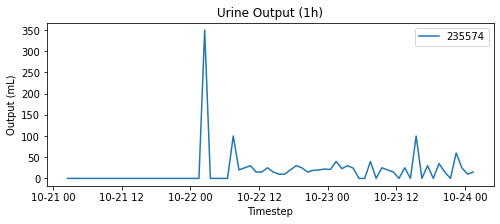

In [78]:
# Grab urine output from random patient
plot_single(data_all, key='total_urine_output', title='Urine Output (%s)' % INTERVAL_TIME, ylabel='Output (mL)', style='-')

### Urine Output Running Total 

In Roggeveen et al. an additional feature `running_total_urine_output` is included in the feature set;

In [79]:
for icustay_id, icustay_data in data_all.items():
    if 'total_urine_output' in icustay_data.keys():
        data_all[icustay_id]['running_total_urine_output'] = np.cumsum(icustay_data['total_urine_output'])

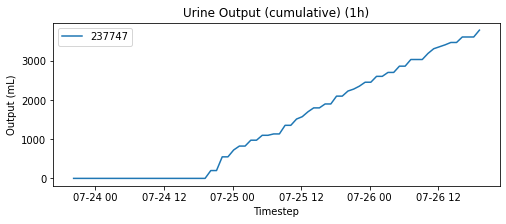

In [80]:
# Grab urine output from random patient
plot_single(data_all, key='running_total_urine_output', title='Urine Output (cumulative) (%s)' % INTERVAL_TIME, ylabel='Output (mL)', style='-')

---
## FiO2 (Fraction of Inspired Oxygen)

In [81]:
fio2_df = read_csv(DATA_DIR + 'fio2_cohort.csv')
fio2_df.head()

,subject_id,hadm_id,icustay_id,charttime,fio2
0,3,145834,211552,2101-10-20 20:00:00,NaN
1,3,145834,211552,2101-10-20 23:15:00,NaN
2,3,145834,211552,2101-10-20 23:45:00,60.000002
3,3,145834,211552,2101-10-21 00:28:00,50.000000
4,3,145834,211552,2101-10-21 04:15:00,50.000000


In [82]:
# Process ICU stays one-by-one
for icustay_id, measurements in tqdm(fio2_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add FiO2 ID to `data_all` to store aggregated measurements
    timesteps = icustay_timesteps[icustay_id]
    data_all[icustay_id]['fi_o2'] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] <= interval_end)  
        
        # Compute average value within timestep
        data_all[icustay_id]['fi_o2'][i] = measurements[condition]['fio2'].mean()
        
del fio2_df

100%|████████████████████████████████████████████████████████████████████████████| 18820/18820 [15:15<00:00, 20.56it/s]


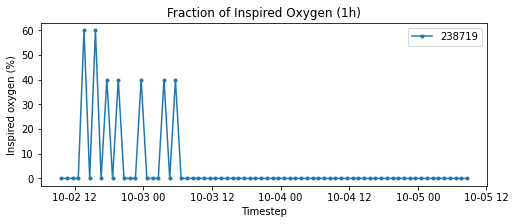

In [83]:
# Grab FiO2 from random patient
plot_single(data_all, key='fi_o2', title='Fraction of Inspired Oxygen (%s)' % INTERVAL_TIME, ylabel='Inspired oxygen (%)')

---
## Demographics

In [84]:
demo_df = pd.read_csv(DATA_DIR + 'demographics_cohort.csv')
demo_df.head()

,subject_id,hadm_id,icustay_id,age,is_male,race_white,race_black,race_hispanic,race_other,height,...,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,elixhauser_hospital,blood_culture_positive
0,27513,163557,200003,48.2940,1,1,0,0,0,177.80,...,1,6,3,4,2,1.0,0.0,1.0,0,1
1,20707,129310,200007,43.3439,1,1,0,0,0,177.80,...,0,1,2,2,2,1.0,0.0,1.0,0,0
2,29904,129607,200009,47.5548,0,1,0,0,0,161.29,...,1,3,4,4,2,1.0,0.0,1.0,-4,0
3,28448,177527,200012,32.9891,0,0,0,0,1,NaN,...,0,1,1,3,2,1.0,0.0,1.0,0,0
4,9514,127229,200014,84.7274,1,0,0,0,1,167.64,...,1,3,5,4,2,1.0,0.0,1.0,0,1


In [85]:
demo_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'age', 'is_male', 'race_white',
       'race_black', 'race_hispanic', 'race_other', 'height', 'weight', 'vent',
       'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score', 'qsofa_gcs_score',
       'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive'],
      dtype='object')

In [86]:
# Define demographics and disease severity scores of interest (on admission)
DEMOGRAPHICS_COLS = ['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs']

In [87]:
for icustay_id, demographics in tqdm(demo_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    timesteps = icustay_timesteps[icustay_id]
    N = len(timesteps) - 1
    
    # Repeat demographics at each timestep
    for feature in DEMOGRAPHICS_COLS:
        data_all[icustay_id][feature] = np.ones(N) * demographics[feature].values[0]
        
del demo_df

100%|██████████████████████████████████████████████████████████████████████████| 38248/38248 [00:14<00:00, 2721.16it/s]


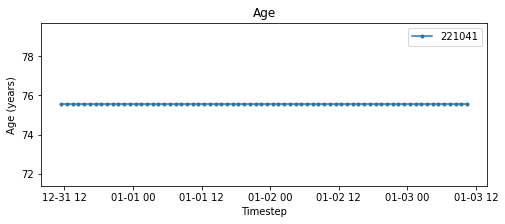

In [88]:
plot_single(data_all, key='age', title='Age', ylabel='Age (years)')

---
# Putting It All Together!

## Add Reward
We define positive terminal reward (R=15) as discharge of patient (survival beyond hospital stay) and negative reward (R=-15) for the passing of the patient in-hospital. No intermediate rewards are issued.

In [89]:
# Mapping from admissions to 30-day mortality labels
mortality_dct = {row['icustay_id']: row['hospital_expire_flag'] for _, row in cohort_df.iterrows()}

for icustay_id, patient in tqdm(cohort_df.groupby('icustay_id')):
    
    if icustay_id not in icustay_timesteps:
        continue
        
    # Determine whether person passed away in hospital
    deceased = mortality_dct[icustay_id]
    
    # Define sparse end-of-episode rewards as +15 on survival; -15 on death
    timesteps = icustay_timesteps[icustay_id]
    rewards = np.zeros(len(timesteps) - 1)
    rewards[-1] = -15 if deceased else 15
    
    data_all[icustay_id]['reward'] = rewards

100%|█████████████████████████████████████████████████████████████████████████| 38248/38248 [00:01<00:00, 37129.45it/s]


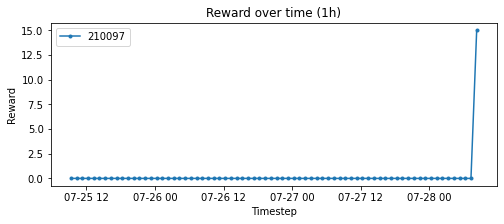

In [90]:
# Grab Reward trajectory from random patient
plot_single(data_all, key='reward', title='Reward over time (%s)' % INTERVAL_TIME, ylabel='Reward')

In [91]:
# Compute mortality rate
survived = 0
total = 1
for icustay in data_all:
    if np.max(data_all[icustay]['reward']) == 15:
        survived += 1
    total += 1
     
print('mortality rate:', 1 - (survived / total))

mortality rate: 0.11469580904075927


## Shift IV/VP Forward
By dropping the last VP/IV value (and prepending a `NaN`) we effectively shift the actions, vasopressor doses and IV fluid intakes, one time-step forward (giving us a state representation containing the *previous* vasopressor/IV dose along with the current non-shifted IV/VP and the associated reward);

In [92]:
for icustay_id, icustay_data in data_all.items():
    
    # Shift actions sequence forward by one
    if 'total_iv_fluid' in data_all[icustay_id]:
        data_all[icustay_id]['total_iv_fluid_prev'] = [np.NaN] + list(data_all[icustay_id]['total_iv_fluid'][:-1])
        
    # Don't forget for running total!
    # Remark: original notebook did not shift running total IV (only total_iv_fluid) 
    # therefore the model was able to relate the current IV level as running_total_iv_fluid - total_iv_fluid_prev!
    if 'running_total_iv_fluid' in data_all[icustay_id]:
        data_all[icustay_id]['running_total_iv_fluid_prev'] = [np.NaN] + list(data_all[icustay_id]['running_total_iv_fluid'][:-1])
        
    if 'max_vaso' in data_all[icustay_id]:
        data_all[icustay_id]['max_vaso_prev'] = [np.NaN] + list(data_all[icustay_id]['max_vaso'][:-1])
        
print('Done!')

Done!


## Convert to DataFrame!

In [93]:
# Mark measurement by decision time `interval_end` (i.e. drop interval_start)
# Note this is slightly different from what the non-aggregated dataset contains
for icustay_id in data_all.keys():
    data_all[icustay_id]['timestep'] = data_all[icustay_id]['timestep'][1:]

# Convert individual icustay dicts into DataFrames
data_all_df = {icustay_id: pd.DataFrame.from_dict(icustay_data) for icustay_id, icustay_data in data_all.items()}

# Add icustay_id as identifier
for icustay_id in data_all_df.keys():
    data_all_df[icustay_id]['icustay_id'] = icustay_id
    
# Merge into one large DataFrame
data_all_df = pd.concat(data_all_df.values()).reset_index(drop=True)
data_all_df.head()

,timestep,glucose,dias_bp,mean_bp,sp_o2,sys_bp,heart_rate,resp_rate,temp_c,base_excess,...,sofa,sirs,reward,icustay_id,total_iv_fluid,running_total_iv_fluid,total_iv_fluid_prev,running_total_iv_fluid_prev,max_vaso,max_vaso_prev
0,2101-10-20 20:10:11,212.0,47.600000,101.555567,74.00,114.200000,143.00,24.0,NaN,-3.333333,...,7.0,3.0,0.0,211552,NaN,NaN,NaN,NaN,NaN,NaN
1,2101-10-20 21:10:11,NaN,44.125000,57.333337,NaN,81.000000,153.75,15.5,NaN,NaN,...,7.0,3.0,0.0,211552,NaN,NaN,NaN,NaN,NaN,NaN
2,2101-10-20 22:10:11,267.0,47.333333,63.222217,98.25,90.666667,137.75,21.0,NaN,-11.000000,...,7.0,3.0,0.0,211552,NaN,NaN,NaN,NaN,NaN,NaN
3,2101-10-20 23:10:11,NaN,64.500000,84.750000,99.75,117.000000,129.25,10.5,NaN,NaN,...,7.0,3.0,0.0,211552,NaN,NaN,NaN,NaN,NaN,NaN
4,2101-10-21 00:10:11,NaN,63.000000,77.000000,98.00,102.000000,146.00,19.0,NaN,NaN,...,7.0,3.0,0.0,211552,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# For conversion rates see https://github.com/LucaMD/SRL/blob/master/SEPSIS/MIMIC_src/MIMIC_R_DataPreprocessing.ipynb
data_final_df = pd.DataFrame({'icustay_id': data_all_df['icustay_id'], 
                              'timestep': data_all_df['timestep'], 
                              # Discretized 'action' (0 - 24) added below
                              'max_vaso': data_all_df['max_vaso'],
                              'max_vaso_prev': data_all_df['max_vaso_prev'],
                              'total_iv_fluid': data_all_df['total_iv_fluid'],
                              'total_iv_fluid_prev': data_all_df['total_iv_fluid_prev'],
                              'reward': data_all_df['reward'],
                              'sirs_score': data_all_df['sirs'],
                              'sofa_score': data_all_df['sofa'],
                              'weight': data_all_df['weight'],
                              'ventilator': data_all_df['vent'],
                              'height': data_all_df['height'],
                              'age': data_all_df['age'],
                              'gender': data_all_df['is_male'],
                              'heart_rate': data_all_df['heart_rate'],
                              'temp': data_all_df['temp_c'],
                              'mean_bp': data_all_df['mean_bp'],
                              'dias_bp': data_all_df['dias_bp'],
                              'sys_bp': data_all_df['sys_bp'],
                              'resp_rate': data_all_df['resp_rate'],
                              'spo2': data_all_df['sp_o2'],
                              'natrium': data_all_df['sodium'],
                              'chloride': data_all_df['chloride'],
                              'kalium': data_all_df['potassium'],
                              'trombo': data_all_df['platelet'],
                              'leu': data_all_df['wbc'],
                              'anion_gap': data_all_df['anion gap'],
                              'aptt': data_all_df['ptt'],
                              'art_ph': data_all_df['ph'],
                              'asat': data_all_df['asat'],
                              'alat': data_all_df['alat'],
                              'bicarbonaat': data_all_df['bicarbonate'],
                              'art_be': data_all_df['base_excess'],
                              'ion_ca': data_all_df['ion_calcium'],
                              'lactate': data_all_df['lactate'],
                              'paco2': data_all_df['paco2'],
                              'pao2': data_all_df['pao2'],
                              'fio2': data_all_df['fi_o2'],
                              'sirs_bands': data_all_df['bands'], # Not part of feature space
                              'shock_index': data_all_df['heart_rate'] / data_all_df['sys_bp'],
                              'hb': data_all_df['hemoglobin'] * 0.6206, # Conversion rates (see original notebook)
                              'bilirubin': data_all_df['bilirubin'] * (1 / 0.05847953),
                              'creatinine': data_all_df['creatinine'] * (1 / 0.01131222),
                              'inr': data_all_df['pt'] / 12,
                              'ureum': data_all_df['bun'] * 0.3571,
                              'albumin': data_all_df['albumin'] * 10,
                              'magnesium': data_all_df['magnesium'] * 0.411,
                              'calcium': data_all_df['calcium'] * 0.25,
                              'pf_ratio': data_all_df['paco2'] / data_all_df['fi_o2'],
                              'glucose': data_all_df['glucose'] * 0.0555,
                              'running_total_urine_output': data_all_df['running_total_urine_output'],
                              'total_urine_output': data_all_df['total_urine_output'],
                              'running_total_iv_fluid_prev': data_all_df['running_total_iv_fluid_prev'],})

In [125]:
# Show data for random patient
icustay_id = random.choice(data_final_df.icustay_id.unique())
data_final_df[data_final_df['icustay_id'] == icustay_id].tail()

,icustay_id,timestep,max_vaso,max_vaso_prev,total_iv_fluid,total_iv_fluid_prev,reward,sirs_score,sofa_score,weight,...,inr,ureum,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid_prev
1968043,234859,2126-08-18 07:00:00,0.0,0.0,239.848541,134.015198,0.0,3.0,2.0,53.9,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5510,3220.0,0.0,6773.731934
1968044,234859,2126-08-18 08:00:00,0.0,0.0,56.515205,239.848541,0.0,3.0,2.0,53.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3420.0,200.0,7013.580566
1968045,234859,2126-08-18 09:00:00,0.0,0.0,119.015198,56.515205,0.0,3.0,2.0,53.9,...,NaN,NaN,NaN,NaN,NaN,NaN,4.2735,3420.0,0.0,7070.095703
1968046,234859,2126-08-18 10:00:00,0.0,0.0,119.015198,119.015198,0.0,3.0,2.0,53.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3620.0,200.0,7189.110840
1968047,234859,2126-08-18 11:00:00,0.0,0.0,19.015205,119.015198,15.0,3.0,2.0,53.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3620.0,0.0,7308.125977


In [126]:
# save intermediate dataset before further processing just in case
data_final_df.to_csv(OUTPUT_DIR + 'partial_data_df.csv', index=False)

## Discretize Action Space

#### Compute Bins

In [127]:
# Compute 5-bin histogram to obtain discrete intervals
def get_quantile_intervals(vals, N=5, max_inf=True, min_inf=True):
    # Drop NaNs and zero doses (they get their own action)
    vals = vals[(vals > 0) & ~np.isnan(vals)].values
        
    # Compute quantiles with special zero bin
    quantiles = [0] + list(np.quantile(vals, np.linspace(0, 1, N)))
    quantiles[0] = -np.inf
    quantiles[1] = 0
    quantiles[-1] = np.inf
    return quantiles
    
max_vp_bins = get_quantile_intervals(data_final_df['max_vaso'])
tot_iv_bins = get_quantile_intervals(data_final_df['total_iv_fluid'])

print('Max VP bins:  ', max_vp_bins)
print('IV fluid bins:', tot_iv_bins)

Max VP bins:   [-inf, 0, 0.10009008646011353, 0.22500909864902496, 0.45003750920295715, inf]
IV fluid bins: [-inf, 0, 21.363636016845703, 84.72233581542969, 199.9966583251953, inf]


<br>

**Sanity Check: Number of actions in each bin**<br>
Each bin should have a good number of samples

In [128]:
max_vp_binned = pd.cut(data_final_df['max_vaso'].fillna(0), 
                       right=True, 
                       bins=max_vp_bins, 
                       labels=[0, 1, 2, 3, 4]).value_counts()

iv_fluid_shifted_binned = pd.cut(data_final_df['total_iv_fluid'].fillna(0), 
                                 right=True, 
                                 bins=tot_iv_bins, 
                                 labels=[0, 1, 2, 3, 4]).value_counts()

pd.DataFrame({'Max VP': max_vp_binned,
              'IV Fluid': iv_fluid_shifted_binned}).transpose()

,0,3,1,2,4
Max VP,2684135,17444,17432,17430,17415
IV Fluid,2280820,118451,118262,118256,118067


#### Convert Continuous Actions to 5x5 Action Space

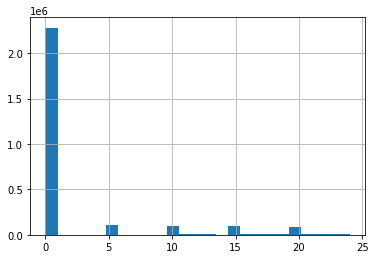

In [129]:
# Replace NaNs by zero (no vasopressor or IV fluid treatment, so dose = zero)
data_final_df['max_vaso'] = data_final_df['max_vaso'].fillna(0)
data_final_df['total_iv_fluid'] = data_final_df['total_iv_fluid'].fillna(0)
data_final_df['max_vaso_prev'] = data_final_df['max_vaso_prev'].fillna(0)
data_final_df['total_iv_fluid_prev'] = data_final_df['total_iv_fluid_prev'].fillna(0)

# Use pd.cut to discretize actions
max_vp_discrete = pd.cut(data_final_df['max_vaso'], 
                         right=True,
                         bins=max_vp_bins, 
                         labels=[0, 1, 2, 3, 4]).astype(float)

total_iv_discrete = pd.cut(data_final_df['total_iv_fluid'],
                           right=True,
                           bins=tot_iv_bins, 
                           labels=[0, 1, 2, 3, 4]).astype(float)

# Compute action as 5 * total_iv_fluid + max_vaso
data_final_df['action'] = 5 * total_iv_discrete + max_vp_discrete
data_final_df['action'].hist(bins=25);

#### Export Action Bins and Action-Bin Mapping

In [130]:
# Save bin edges of max_vaso and total_iv_fluid as .npy files for later reference
with open(OUTPUT_DIR + 'max_vaso_bins.npy', 'w') as file:
    np.savetxt(file, max_vp_bins)
    
with open(OUTPUT_DIR + 'total_iv_fluid_bins.npy', 'w') as file:
    np.savetxt(file, tot_iv_bins)
    
print('Done!')

Done!


In [131]:
# Save mapping from action indices (0 to 24) to bin indices (0 to 4)
action_id_to_bins = dict()
for max_vaso in range(5):
    for total_iv_fluid in range(5):
        action_id_to_bins[5 * total_iv_fluid + max_vaso] = (total_iv_fluid, max_vaso)

with open(OUTPUT_DIR + 'action_to_vaso_fluid_bins.pkl', 'wb') as file:
    pickle.dump(action_id_to_bins, file)
    
print('Done!')

Done!


## Cap Outlying Measurements

During exploratory data analysis it was found that the data was riddled with measurement errors, whereby treatment and vital parameters would take values orders in magnitude higher than would be possible (or safe practice). To ensure feature normalization will not too much be affected by these values, we will cap values to their respective minimum or maximum when outside of their clinically possible range.

However, slight modifications are made to the capping values used in (Roggeveen et al., 2021)
1. Max. `anion_gap`: 12 $\rightarrow$ 40 (as 12 can be considered an acceptable value for even healthy patients depending on the lab and how the test was performed, see [Wikipedia's entry for Anion Gap](https://en.wikipedia.org/wiki/Anion_gap))
2. Min. `shock_index`: 0.5 $\rightarrow$ 0.4 (a value of 0.5 was very often measured (>22.000) and thus the range was slightly relaxed compared to Roggeveen et al.)

In [135]:
# Load capping values (roggeveen et al., 2021)
min_max_values = pd.read_csv('capping_values.csv').set_index('parameter').to_dict('index')

print('Numbers capped:')
for feature, rng in min_max_values.items():
    # Cap values with bounds specific to feature
    capped_values = data_final_df[feature].clip(lower=rng['minval'], upper=rng['maxval'])
        
    # Count non-NaN measurements capped
    num_capped = ((capped_values != data_final_df[feature]) * capped_values.notna()).sum()
    
    # Print features for which many values were capped
    if num_capped > 100:
        print(feature, num_capped)      
    
    data_final_df[feature] = capped_values

Numbers capped:
age 6408
aptt 487
bilirubin 145
calcium 249
chloride 323
dias_bp 870
fio2 148
glucose 577
height 3600
leu 354
magnesium 264
mean_bp 628
natrium 166
paco2 1093
pao2 702
resp_rate 2865
shock_index 2749
weight 1728


## Drop No-Treatment Admissions

There are many admissions in which no hemodynamic treatments are prescribed at all (No IV, nor VP); We will filter out these treatments as done in Roggeveen et al.;

In [136]:
# Identify admissions where treatments were registered (at least one action > 0)
admission_has_treatment = data_final_df.groupby('icustay_id', sort=False)['action'].max() > 0
icustay_ids = admission_has_treatment.index[admission_has_treatment.values]

# Drop all non-treatment admissions
data_final_df = data_final_df[data_final_df['icustay_id'].isin(icustay_ids)]

In [137]:
# How many admissions do we have left?
print('Number of admissions after filtering:', len(icustay_ids))

Number of admissions after filtering: 14243


## Training, Validation and Test

To train and test the model we need dedicated training, validation (e.g. for hyperparameter tuning) and test sets. We perform the splitting below;

In [138]:
# For reproduction sake!
random.seed(10)

In [139]:
# Specify fraction of ICU-stays for training, validation and testing
frac_train = 0.7
frac_valid = 0.1

# Randomly assign icustay_ids to train, val and test
icustay_ids = list(data_final_df['icustay_id'].unique())
random.shuffle(icustay_ids)

num_train = int(len(icustay_ids) * frac_train)
num_valid = int(len(icustay_ids) * frac_valid)

train_icustays = icustay_ids[:num_train]
valid_icustays = icustay_ids[num_train:num_train + num_valid]
test_icustays = icustay_ids[num_train + num_valid:]

# Store train/valid/test icustay_ids
np.savetxt(OUTPUT_DIR + 'mimic-iii_icustay_ids_train.npy', train_icustays)
np.savetxt(OUTPUT_DIR + 'mimic-iii_icustay_ids_valid.npy', valid_icustays)
np.savetxt(OUTPUT_DIR + 'mimic-iii_icustay_ids_test.npy', test_icustays)

print('Dataset instances:')
print('Train  %s' % len(train_icustays))
print('Valid  %s' % len(valid_icustays))
print('Test   %s' % len(test_icustays))

Dataset instances:
Train  9970
Valid  1424
Test   2849


In [140]:
data_train_df = data_final_df[data_final_df['icustay_id'].isin(train_icustays)].reset_index(drop=True)
data_valid_df = data_final_df[data_final_df['icustay_id'].isin(valid_icustays)].reset_index(drop=True)
data_test_df = data_final_df[data_final_df['icustay_id'].isin(test_icustays)].reset_index(drop=True)
print('Done!')

Done!


## Imputation

### Forward-Filling Imputation

Lab results are made very infrequently, therefore most timesteps will miss these values. We follow (Roggeveen et al., 2021) and use forward-filling (or Last-Value Carried Forward Imputations) to impute these missing values:

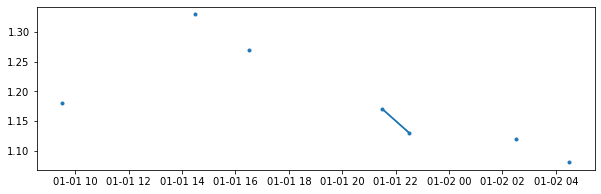

In [164]:
icustay_id = plot_random(data_train_df, key='ion_ca')

In [165]:
# Columns corresponding to lab measurements
FFILL_COLS = ['natrium', 'chloride', 'kalium', 'trombo', 'leu', 'anion_gap', 'aptt', 'art_ph', 
              'asat', 'alat', 'bicarbonaat', 'art_be', 'ion_ca', 'lactate', 'paco2', 'pao2', 
              'fio2', 'sirs_bands', 'shock_index', 'hb', 'bilirubin', 'creatinine', 'inr', 
              'ureum', 'albumin', 'magnesium', 'calcium', 'pf_ratio', 'glucose', 'fio2']

assert all([c in data_train_df.columns for c in FFILL_COLS])

In [166]:
for dataset in [data_train_df, data_valid_df, data_test_df]:
    for col in FFILL_COLS:
        dataset.loc[:, col] = dataset.groupby('icustay_id', sort=False)[col].ffill()

230380

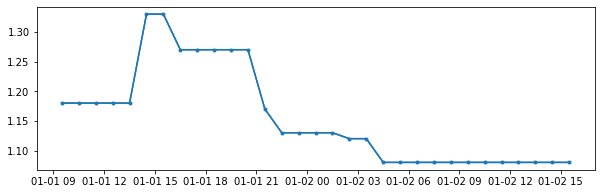

In [167]:
plot_random(data_train_df, key='ion_ca', icustay_id=icustay_id)

### Linear Interpolation
As sometimes only single points are missing between otherwise adjacent measurements we use linear interpolation to fill in these gaps. This prevents the possibility of the kNN imputer (next up) to add noise to these fairly certain values.

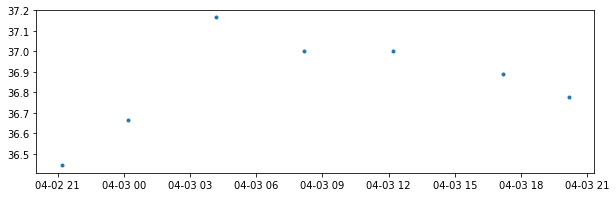

In [168]:
icustay_id = plot_random(data_train_df, key='temp')

In [169]:
# Columns corresponding to lab measurements
INTERP_COLS = ['heart_rate', 'temp', 'mean_bp', 'dias_bp', 'sys_bp', 'resp_rate', 'spo2', 
               'running_total_urine_output', 'total_urine_output']

In [170]:
for dataset in [data_train_df, data_valid_df, data_test_df]:
    icustay = dataset.groupby('icustay_id', sort=False)
    for col in tqdm(INTERP_COLS, position=0, leave=True):
        dataset[col] = icustay[col].apply(lambda group: group.interpolate(method='linear', limit_area='inside', limit=1)) # Max 2 steps apart and no extrapolation!

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


204180

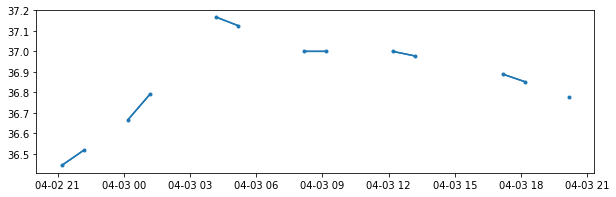

In [171]:
plot_random(data_train_df, key='temp', icustay_id=icustay_id)

### KNN Imputation
Some points that are missing lie 'outside' of the recorded set of measurements (i.e. there is no point to the left or right) or multiple-adjacent values are missing -- to resolve these we need extrapolation. To this end, we use a kNN-based imputation with k=3 nearest neighbors within episode.

In [174]:
# Example of admissions with all NaNs in one column
for icustay_id, example in data_train_df.groupby('icustay_id'):
    if np.any(example.isna().all(axis=0)):
        break
        
all_missing = example.isna().all(axis=0)
print('Columns with all NaNs:', all_missing.index[all_missing].to_list())

Columns with all NaNs: ['height', 'asat', 'alat', 'sirs_bands', 'bilirubin', 'albumin']


In [175]:
# We define the field to be KNN imputed as the combined set of lab results and vitals
IMPUTING_FIELDS = INTERP_COLS + FFILL_COLS + ['running_total_iv_fluid_prev']

In [176]:
def impute_with_knn(dataset, imputing_fields):
    X_result = []
    for icustay_id, group_data in tqdm(dataset.groupby('icustay_id', sort=False), position=0, leave=True):
        # Impute features using KNN
        X_incomplete = group_data[imputing_fields]       
        X_imputed = KNN(k=3, verbose=False).fit_transform(X_incomplete)
        
        # If the column was all NaNs, the KNN sets these values to all zeroes
        # As mean imputation is preferred in this case, we put back the NaNs for now
        all_missing = X_incomplete.isna().all(axis=0).values
        X_imputed[:, all_missing] = np.NaN
        
        X_result.append(X_imputed)
                
    # Concatenate into large ndarray
    X_result = np.concatenate(X_result, axis=0)
    
    # Fill in DataFrame column-by-column
    for i, f in enumerate(imputing_fields):
        dataset.loc[:, f] = X_result[:, i]
    return dataset

data_train_df = impute_with_knn(data_train_df, IMPUTING_FIELDS)
data_valid_df = impute_with_knn(data_valid_df, IMPUTING_FIELDS)
data_test_df = impute_with_knn(data_test_df, IMPUTING_FIELDS)

data_valid_df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 2849/2849 [00:58<00:00, 48.92it/s]


,icustay_id,timestep,max_vaso,max_vaso_prev,total_iv_fluid,total_iv_fluid_prev,reward,sirs_score,sofa_score,weight,...,ureum,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid_prev,action
0,227049,2181-07-30 22:11:19,0.0,0.0,0.000000,0.000000,0.0,3.0,1.0,91.4,...,5.3565,NaN,1.0686,2.175,NaN,7.3815,0.0,0.0,129.454122,0.0
1,227049,2181-07-30 23:11:19,0.0,0.0,97.295898,0.000000,0.0,3.0,1.0,91.4,...,5.3565,NaN,1.0686,2.175,NaN,7.3815,500.0,500.0,0.000000,15.0
2,227049,2181-07-31 00:11:19,0.0,0.0,100.104378,97.295898,0.0,3.0,1.0,91.4,...,5.3565,NaN,1.0686,2.175,NaN,7.3815,500.0,0.0,97.295898,15.0
3,227049,2181-07-31 01:11:19,0.0,0.0,100.104378,100.104378,0.0,3.0,1.0,91.4,...,5.3565,NaN,1.0686,2.175,NaN,7.3815,670.0,170.0,197.400269,15.0
4,227049,2181-07-31 02:11:19,0.0,0.0,100.104378,100.104378,0.0,3.0,1.0,91.4,...,5.3565,NaN,1.0686,2.175,NaN,7.3815,670.0,0.0,297.504639,15.0


### Mean Imputation

If no data was recorded for a certain feature and patient at all, we fall back on imputation using the mean of each column;

In [177]:
data_train_df = data_train_df.fillna(data_train_df.mean(numeric_only=True))
data_valid_df = data_valid_df.fillna(data_valid_df.mean(numeric_only=True))
data_test_df = data_test_df.fillna(data_test_df.mean(numeric_only=True))

data_valid_df.head()

,icustay_id,timestep,max_vaso,max_vaso_prev,total_iv_fluid,total_iv_fluid_prev,reward,sirs_score,sofa_score,weight,...,ureum,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid_prev,action
0,227049,2181-07-30 22:11:19,0.0,0.0,0.000000,0.000000,0.0,3.0,1.0,91.4,...,5.3565,32.975663,1.0686,2.175,0.770716,7.3815,0.0,0.0,129.454122,0.0
1,227049,2181-07-30 23:11:19,0.0,0.0,97.295898,0.000000,0.0,3.0,1.0,91.4,...,5.3565,32.975663,1.0686,2.175,0.770716,7.3815,500.0,500.0,0.000000,15.0
2,227049,2181-07-31 00:11:19,0.0,0.0,100.104378,97.295898,0.0,3.0,1.0,91.4,...,5.3565,32.975663,1.0686,2.175,0.770716,7.3815,500.0,0.0,97.295898,15.0
3,227049,2181-07-31 01:11:19,0.0,0.0,100.104378,100.104378,0.0,3.0,1.0,91.4,...,5.3565,32.975663,1.0686,2.175,0.770716,7.3815,670.0,170.0,197.400269,15.0
4,227049,2181-07-31 02:11:19,0.0,0.0,100.104378,100.104378,0.0,3.0,1.0,91.4,...,5.3565,32.975663,1.0686,2.175,0.770716,7.3815,670.0,0.0,297.504639,15.0


In [178]:
assert np.all(data_train_df.notna())

## Feature Standardization
To satisfy the input assumptions of neural networks, we standardize the input features to be centered and approximately normal. To this end, we perform various transformations (e.g. log transforms) to standardize the data. These transformations are guided by the value distributions seen in the [exploratory data analysis](https://github.com/thomas097/Haemodynamic-Optimization-Reinforcement-Learning/tree/main/exploratory_analysis) (EDA);

In [179]:
# Which field need to be log-transformed was found in the EDA
BINARY_FIELDS = ['ventilator', 'gender']
LOG_FIELDS = ['max_vaso_prev', 'spo2', 'ureum', 'creatinine', 'alat', 'asat', 'bilirubin', 'inr', 'total_iv_fluid_prev', 
              'running_total_iv_fluid_prev', 'running_total_urine_output', 'total_urine_output']
EXCLUDE = ['icustay_id', 'timestep', 'reward', 'state_sirs', 'action', 'max_vaso', 'total_iv_fluid']

### Z-scoring and Log-Transformation

In [180]:
def log_transform(x):
    return np.log(x + 0.1)

def zscore(x, mean, stdev):
    return (x - mean) / stdev

In [181]:
# Estimate feature means/stdevs from training set
params = dict()
for col in data_train_df.columns:
    if col not in EXCLUDE:
        x = data_train_df[col] if col not in LOG_FIELDS else log_transform(data_train_df[col])
        params[col] = (x.mean(), x.std())

# Perform stndardization with values from data_train_df
for df in [data_train_df, data_valid_df, data_test_df]:
    for col in tqdm(df.columns):
        if col not in EXCLUDE:
            # Binary (e.g. vent, gender)
            if col in BINARY_FIELDS:
                df[col] = df[col] - 0.5           
            else:
                # Z-scoring + optional log transform
                x = log_transform(df[col]) if col in LOG_FIELDS else df[col]
                df[col] = zscore(x, *params[col])
                
print('Done!')

100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 297.90it/s]

Done!


### MinMax Normalization
After Z-scoring Roggeveen et al. scales all features using MinMax normalization, which we will repeat for good measure (although it undoes some of the previous normalization steps);

In [182]:
# for col in tqdm(df.columns):
#     if col not in EXCLUDE:
#         # Min/max estimates from training set!
#         train_min = data_train_df[col].min()
#         train_max = data_train_df[col].max()
        
#         data_train_df[col] = (data_train_df[col] - train_min) / (train_max - train_min)
#         data_valid_df[col] = (data_valid_df[col] - train_min) / (train_max - train_min)
#         data_test_df[col] = (data_test_df[col] - train_min) / (train_max - train_min)
        
# print('Done!')
# data_train_df.head()

## Rename Columns to `X*`

In the source code we may wish to refer to the list of features without defining the names of the features each time, i.e. `['heart_rate', 'albumin', 'leu', 'resp_rate', 'fio2', ...]` etc. Much easier is to simply refer to the columns as `x0` to `x49` which we can create procedurally. Below we will define a mapping from state-space features to their `x*`equivalents;

In [183]:
STATE_SPACE_COLUMNS = ['max_vaso_prev', 'total_iv_fluid_prev', 'sirs_score', 'sofa_score', 'weight', 'ventilator', 'height', 'age', 'gender',
                       'heart_rate', 'temp', 'mean_bp', 'dias_bp', 'sys_bp', 'resp_rate', 'spo2', 'natrium', 'chloride', 'kalium', 'trombo', 
                       'leu', 'anion_gap', 'aptt', 'art_ph', 'asat', 'alat', 'bicarbonaat', 'art_be', 'ion_ca', 'lactate', 'paco2', 'pao2', 
                       'fio2', 'sirs_bands', 'shock_index', 'hb', 'bilirubin', 'creatinine', 'inr', 'ureum', 'albumin', 'magnesium', 'calcium', 
                       'pf_ratio', 'glucose', 'running_total_urine_output', 'total_urine_output', 'running_total_iv_fluid_prev']

# Check if all features in `data_train_df`
for col in STATE_SPACE_COLUMNS:
    if col not in data_train_df:
        raise Exception('%s not in data_train_df' % col)

# Write out file for later reference
with open(OUTPUT_DIR + 'state_space_features.txt', 'w') as f:
    for col in STATE_SPACE_COLUMNS:
        f.write("%s\n" % col)

In [184]:
# Create x* name for each column
new_state_space_columns = {feat:'x%s' % i for i, feat in enumerate(STATE_SPACE_COLUMNS)}

# Replace 'icustay_id' by 'episode'
new_state_space_columns['icustay_id'] = 'episode'

# Rename columns
data_train_df = data_train_df.rename(columns=new_state_space_columns)
data_valid_df = data_valid_df.rename(columns=new_state_space_columns)
data_test_df = data_test_df.rename(columns=new_state_space_columns)

In [185]:
data_train_df.columns

Index(['episode', 'timestep', 'max_vaso', 'x0', 'total_iv_fluid', 'x1',
       'reward', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',
       'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31',
       'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41',
       'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'action'],
      dtype='object')

## Drop Impossible Actions

Just in case there are any, drop instances where no IV fluids are given but vasopressor is administered (actions 0-4). This should not be possible as vasopressors are, in fact, fluids themselves!

In [186]:
DISALLOWED_ACTIONS = [1, 2, 3, 4]

In [187]:
for dataset in [data_train_df, data_valid_df, data_test_df]:
    not_allowed = dataset.action.isin(DISALLOWED_ACTIONS)
    print('Dropping', np.sum(not_allowed))
    dataset.loc[not_allowed, 'action'] = 0

Dropping 53
Dropping 14
Dropping 18


In [188]:
# How many 1's are still in the training dataset?
np.sum(data_train_df.action == 1)

0

## Final Details

In [189]:
# Sort by timestep and episode
data_train_df = data_train_df.sort_values(['episode', 'timestep'])
data_valid_df = data_valid_df.sort_values(['episode', 'timestep'])
data_test_df = data_test_df.sort_values(['episode', 'timestep'])

## Export Datasets

In [190]:
# Don't forget to save!!
data_train_df.to_csv(OUTPUT_DIR + 'mimic-iii_train.csv', index=False)
data_valid_df.to_csv(OUTPUT_DIR + 'mimic-iii_valid.csv', index=False)
data_test_df.to_csv(OUTPUT_DIR + 'mimic-iii_test.csv', index=False)
print('Done!')

Done!


#### Memory Usage

In [191]:
# Size of current dataset with current ICU stays
num_icustay_ids = len(data_final_df['icustay_id'].unique())
print('Number of ICU-stay ids:', num_icustay_ids)

full_df_gigs = data_final_df.memory_usage(deep=True).sum() / (1 << 30)
print('Expected memory usage of dataset: %sGB' % round(full_df_gigs, 2)) 

Number of ICU-stay ids: 14243
Expected memory usage of dataset: 0.41GB


---

## Sanity Checks

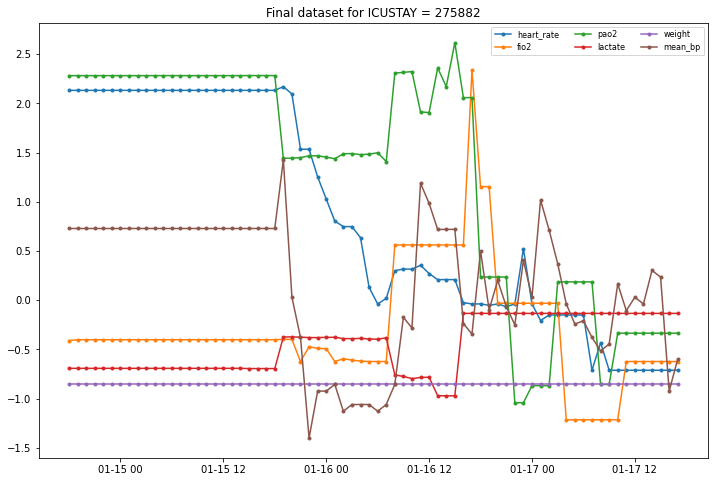

In [282]:
# Limit plot to one ICU stay
icustay_id = random.choice(list(data_train_df['episode'].unique()))
icustay_df = data_train_df[data_train_df['episode'] == icustay_id]

# change this to visualize other feature
FEATURES = ['heart_rate', 'fio2', 'pao2', 'lactate', 'weight', 'mean_bp']

plt.figure(figsize=(12, 8))
for f in FEATURES:
    x_name = 'x%d' % STATE_SPACE_COLUMNS.index(f)
    plt.plot(icustay_df['timestep'], icustay_df[x_name], label=f, marker='.')
        
plt.title('Final dataset for ICUSTAY = %s' % icustay_id)
plt.legend(ncol=3, prop={'size': 8})
plt.show()

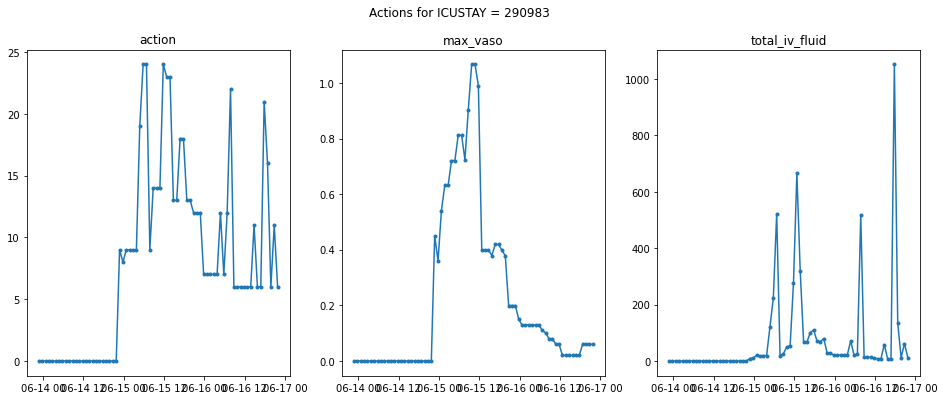

In [310]:
# Limit plot to one ICU stay
icustay_id = random.choice(list(data_train_df['episode'].unique()))
icustay_df = data_train_df[data_train_df['episode'] == icustay_id]

# Plot interesting columns
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.title('action')
plt.plot(icustay_df['timestep'], icustay_df['action'], marker='.')

plt.subplot(1, 3, 2)
plt.title('max_vaso')
plt.plot(icustay_df['timestep'], icustay_df['max_vaso'], marker='.')

plt.subplot(1, 3, 3)
plt.title('total_iv_fluid')
plt.plot(icustay_df['timestep'], icustay_df['total_iv_fluid'], marker='.')
        
plt.suptitle('Actions for ICUSTAY = %s' % icustay_id)
plt.show()

### General Statistics

In [301]:
train_df = pd.read_csv(OUTPUT_DIR + '/mimic-iii_train.csv')
print('Admissions:')
print('Train:', len(data_train_df['episode'].unique()))
print('Valid:', len(data_valid_df['episode'].unique()))
print('Test: ', len(data_test_df['episode'].unique()))

Admissions:
Train: 9970
Valid: 1424
Test:  2849


In [302]:
actionable_episodes = (train_df.groupby('episode')['action'].max() > 0).sum()
print('Training admissions with non-zero actions:', actionable_episodes)

Training admissions with non-zero actions: 9970


In [308]:
print('Actions with VP: %.2f' % (100 * (1 - train_df.action.isin([0, 5, 10, 15, 20]).mean())), '%')

Actions with VP: 6.84 %
